# Problem sheet 2 (Group 33)


## Setup stuff 

In [21]:
#set up stuff 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers(df,lq=0,hq=1):
    #df: Dataframe with only the variables to trim
    # lq: lowest quantile. hq:Highest quantile
    columns = pd.Series(df.columns.values).tolist()
    for serie in columns:
        df["houtliers_"+serie] = df[serie].quantile(hq)
        df[df[serie]>df["houtliers_"+serie]] = np.nan
        df["loutliers_"+serie] = df[serie].quantile(lq)
        df[df[serie]<df["loutliers_"+serie]]= np.nan
        del df["houtliers_"+serie], df["loutliers_"+serie]
    return df


def gini(array):
    # from: https://github.com/oliviaguest/gini
    #http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm 
    array = np.array(array)
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array += np.amin(array) #non-negative
    array += 0.0000001 #non-0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) 
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 


def data_stats(data, percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]):
    ### Compute mean, sd, min, max, quintiles and Gini of the states in the state list.
    # Inputs -----------------
    # Dataframe
    
    #Obtain the describtive statistics for the state variables.    
        
    summary = data.describe(percentiles)
    summary.reset_index(inplace=True)
        
    #Generate Gini statistic:
    gini_stat = np.empty(len(data.columns)).reshape(1,len(data.columns))
    
    for i, var in enumerate(data.columns):
        gini_stat[:,i] = gini(data[var].dropna())
                
    data_gini = pd.DataFrame(gini_stat, columns=data.columns)    
    data_gini.reset_index(inplace=True)
    data_gini['index'] = 'Gini'
    summary = summary.append(data_gini, ignore_index=True)
    summary.set_index('index', inplace=True)
    
    return summary


def plot_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value))
           
        plt.title('Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        
        return plt.show()
        
def plot_cum_cond_log_distr(data, variable1, variable2, save=False):
        fig, ax = plt.subplots()
        a = data[variable2].unique()
        for value in a:           
            sns.distplot((np.log(data.loc[data[variable2] == value][variable1]).replace([-np.inf, np.inf], np.nan)).dropna()-np.mean((np.log(data[variable1]).replace([-np.inf, np.inf], np.nan)).dropna()), label=variable2+str(value), hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
        plt.title('Cumulative Distribution of '+variable1+' in Uganda')
        plt.xlabel(variable1)
        ax.legend()
        return plt.show()       




## Exercise 1 
1a) Are there duplicate households in the data? That is check if there are repeated observations in the unique household identifier variable (’hhid’). How many observations are there in the data?

In [3]:
#import data
df1 = pd.read_excel("UNPS_1112_PS2.xls")

#1a
#count number of duplicates in column hhid 
print("the number of duplicates is ",df1.hhid.duplicated().sum() )

print("there are ", len(df1["hhid"]), "observations.")

the number of duplicates is  0
there are  2613 observations.


### 1b) 
Present some basic summary statistics for the following variables: head_gender, head _age, familysize, consumption, income, wealth. Comment your results in 2 lines. In particular, you might mention if there are missing observations or potential outliers for some of the variables.

- head_gender	gender of the household head: 1 if male, 2 if female.
- head_age	age of the household head 
- consumption	total household consumption (excluding durables). In 2013 dollars, adjusted for inflation.
- income -total household income. In 2013 dollars, adjusted for inflation.
- wealth - total household wealth. In 2013 dollars, adjusted for inflation.




In [3]:

#summary statistics 
df1[['head_gender','head_age','income','wealth','consumption']].describe()

,head_gender,head_age,income,wealth,consumption
count,2597.000000,2597.000000,2613.000000,2613.000000,2613.000000
mean,1.314209,46.068156,1860.075795,4912.698146,1803.792687
std,0.464289,15.068960,2607.517603,8359.886497,1308.742941
min,1.000000,14.000000,27.486921,0.000000,250.305506
25%,1.000000,34.000000,471.204368,720.019916,918.324958
50%,1.000000,44.000000,1061.194208,2108.598380,1426.614855
75%,2.000000,56.000000,2234.800590,5221.939857,2296.859516
max,2.000000,100.000000,52137.736864,76396.339917,8369.898484


In [15]:
#then do a grouby gender (already asked for in 1d)
#df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

In [5]:
#Checking for na values
print(df1[['head_gender','head_age','income','wealth','consumption']].isna().sum())
#from the observation there are null values for head_gender and head_age 
#for a more accurate representation of gender statistics we will remove the corresponding rows from the dataframe

#drop rows with NaNs corresponding to the 2 above
#df1.dropna(subset=['head_gender', 'head_age'], inplace=True)


##########################################go back to this one i think we were given a function for outliers in the setup 
#check the number of outliers 
#we define an outlier to be an observation more than 3 s.d
#from the mean 
col = ['head_gender','head_age','income','wealth','consumption']
for i in col:
    mean = df1[i].mean()
    sd = df1[i].std()
    outlier = df1[i] > mean+(3*sd) 
    sum_outliers = outlier.sum()
    
    print('for column: {}'.format(i))
    print("the number of outliers are", sum_outliers, "\n")
    




head_gender    16
head_age       16
income          0
wealth          0
consumption     0
dtype: int64
for column: head_gender
the number of outliers are 0 

for column: head_age
the number of outliers are 5 

for column: income
the number of outliers are 50 

for column: wealth
the number of outliers are 63 

for column: consumption
the number of outliers are 59 



In [113]:
# #we can also clean the dataframe of possible outliers 
# #remove outliers that lie more 
# #than 3 standard deviations away from the mean

# col = ['head_age','income','wealth','consumption']
# for i in col:
#     mean = df1[i].mean()
#     sd = df1[i].std()
#     df1 = df1[(df1[i] <= mean+(3*sd))] 
    
#this returns a dataframe with the outliers removed

#albert has given a function to remove the outliers , but when askeed in tutorial he said i should not remove it 


In [42]:
#after cleaning we apply the previous summary statisitcs:

df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.388546,2061.184846,5278.582949,1898.303754
2.0,49.734069,1417.438044,4072.893135,1593.261206


### explanation here 

### 1c

Using the head_gender variable, create a dummy variable for household head being female (1=female, 0=male). Be careful with missing values. What is the proportion of households where the head is female?

In [24]:
#previously we have removed missing values from the 
#data frame

#generate female dummy variable column , the output 

female = pd.get_dummies(df1['head_gender'])

# remove column corresponding to male == 1 
female = female.drop([1.0],axis = 1) 


proportion = female.mean()
print('proportion of females =', proportion) 

#rename column 2.0 to female and concatate to df1
female.rename(columns={2.0:'female'}, inplace=True)
df1 = pd.concat([df1, female], axis=1)




proportion of females = 2.0    0.312285
dtype: float64
      female
0          0
1          0
2          0
3          0
4          1
...      ...
2608       1
2609       0
2610       1
2611       0
2612       0

[2613 rows x 1 columns]
(2613, 31)


### 1d 

Using the groupby method, compute the average consumption, average household size, and average household head age for households where the head is male vs where the head is female. Do we observe noticeable differences across the two groups

In [14]:

df1[['head_gender','head_age','income','wealth','consumption']].groupby(by='head_gender').mean()

,head_age,income,wealth,consumption
head_gender,,,,
1.0,44.388546,2061.184846,5278.582949,1898.303754
2.0,49.734069,1417.438044,4072.893135,1593.261206


Both male and female lead households had similar consumption levels, with male lead households slightly higher. There was a larger discrepancy in wealth, as male lead households had an average wealth of $1,200 more. Male households also had higher average income, though to a lesser extent than wealth. On average, female household leaders were 5 years older than male ones.

# Exercise 2 
2a) Create the variables log_c, log_inc, log_w that are the log of consumption, income, and wealth, respectively. Plot in the same graph the distribution of the log of consumption and the log of income. Do the distributions resemble some known distribution? Is inequality higher in consumption or in income?

C:\Users\my\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\my\AppData\Local\Temp\ipykernel_6840\1254332674.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_c, label='log_c')
C:\Users\my\AppData\Local\Temp\ipykernel_6840\1254332674.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use

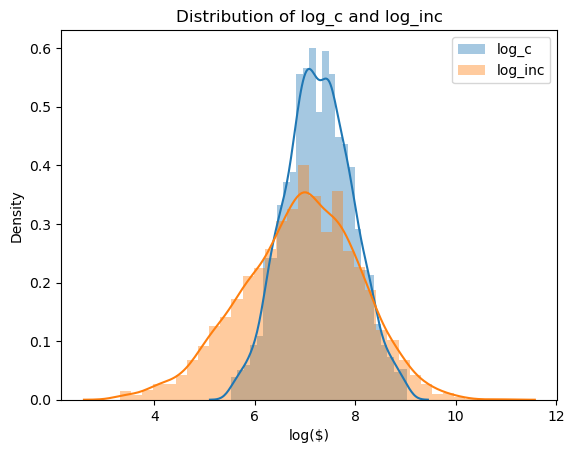

In [94]:
import seaborn as sns 

#define variables 
log_c = np.log(df1[['consumption']]) #
log_inc = np.log(df1[['income']]) #
log_w = np.log(df1[['wealth']])


log_w.isna().sum()

#plotting
fig, ax = plt.subplots()
sns.distplot(log_c, label='log_c')
sns.distplot(log_inc, label='log_inc')
plt.title('Distribution of log_c and log_inc')
ax.legend()
plt.xlabel('log($)')
plt.show()




#plot distribution plot

# print(log_c)



In [ ]:
# The distributions resemble the normal distribution 
# There is higher income inequality (log_inc) as there is higher disparity (a flatter bell curve) 
# between the extremes of income levels than there are for consumpiton levels. Consumption levels are 
# more concentrated, whereas income levels are much more spread out. 

### 2b

A commonly used statistic to measure inequality is the variance of the logs. Compute the variance of the log of consumption, of the log of income, and of the log of wealth. How do these measures of inequality in Uganda compare to the same measures of inequality in the United States? Use table 3, column 5–PSID in De Magalhães, L., & Santaeulàlia-Llopis, R. (2018) for the comparison.


In [37]:
#checking NAs and zeros in wealth 
print("number of NAs in wealth",df1['wealth'].isna().sum())
num_zeros = (df1['wealth'] == 0).sum()
print("Number of zeros in wealth: ", num_zeros)

number of NAs in wealth 0
Number of zeros in wealth:  16


In [44]:
### Ignore, did some debugging here 

# log_w = np.log(df1[['wealth']])

# #check to see if there are any Nan values 
# print(df1['wealth'].isna().sum())
# num_zeros = (df1['wealth'] == 0).sum()
# print("Number of zeros in wealth: ", num_zeros)
# print("number pf Nans in wealth",df1['wealth'].isna().sum())



# #change zeros to mean value in the data frame
# mean = df1['wealth'].mean
# wealth = np.where(df1['wealth'] == 0, mean, df1['wealth'])
# num_zeros = (wealth == 0).sum()
# print("Number of zeros in wealth: ", num_zeros)
# #Print the result
# #print("Number of zeros in wealth: ", num_zeros)
# log_w = np.log(df1[['wealth']])

# #check to see if there are any Nan values 
# num_zeros = (log_w == 0).sum()
# print("Number of zeros in log wealth: ", num_zeros)
# print("number pf Nans in log wealth",log_w.isna().sum())

# log_w.var()

In [47]:
#variance
l1 = [log_c,log_inc,log_w]
vars = []


for i in l1:
    vars.append(i.var())
    
print(vars)



#not sure why wealth is still outputting na values even 
#after logging the values (ask for help)




[consumption    0.44956
dtype: float64, income    1.338737
dtype: float64, wealth   NaN
dtype: float64]


### 2c


In [49]:

#2c
#a. Compute the average consumption, income, 
# and wealth for rural and urban areas separately (groupby).

df1[['urban','income','wealth','consumption']].groupby(by='urban').mean()
#2d


#both should be straightforward therefore skip 


,income,wealth,consumption
urban,,,
0,1713.962054,4520.995235,1629.450928
1,2480.619091,6576.255691,2544.220036


2c: Yes, the differences between consumption & income levels in rural vs urban areas are large, with the consumption seeing the highest relative increase and wealth having the highest nominal increase. 

### 2d
. Measuring within rural and urban inequality in Uganda. Compute the variance of the log of consumption, income, and wealth for rural and urban areas separately (groupby).

In [98]:
#import data to ensure 
df1 = pd.read_excel("UNPS_1112_PS2.xls")


#renaming the columns
log_c.rename(columns={'consumption':'log_c'}, inplace=True)
log_inc.rename(columns={'income':'log_inc'}, inplace=True)
log_w.rename(columns={'wealth':'log_w'}, inplace=True)

#concatenate dataframes
df1 = pd.concat([df1, log_c, log_inc, log_w],axis = 1,join='inner') 


df1[['urban','log_c','log_inc','log_w']].groupby(by='urban').var()

,log_c,log_inc,log_w
urban,,,
0,0.413955,1.342474,NaN
1,0.439342,1.107938,NaN


In [51]:
#2e , compute gini coefficient  income, consumption ,wealth

gini_inputs = ['income', 'wealth', 'consumption']
gini_outputs = []
for i in gini_inputs:
    gini_outputs.append(gini(df1[i]))

print(gini_outputs)

[0.5549803385391477, 0.6552327376953638, 0.3650978225545564]


Gini coeffiecients: income, wealth, comsumption 
            Uganda:  .555   .655      .365 
               USA:  .97    2.11      .79

The USA has significantly higher Gini coefficients that Uganda, espeiclaly with regards to wealth. 

In [99]:
#2f Compute the share of the wealth that the bottom
#50 percent hold. Compute the share of the wealth 
#that the top 10, 5, and 1 percent hold.

data_stats(df1[['wealth']])
#i realise the code above is not what they want have to find another way to do it 


C:\Users\my\AppData\Local\Temp\ipykernel_6840\1695556016.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(data_gini, ignore_index=True)
C:\Users\my\AppData\Local\Temp\ipykernel_6840\1695556016.py:32: RuntimeWarning: invalid value encountered in multiply
  return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))
C:\Users\my\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\my\AppData\Local\Temp\ipykernel_6840\1695556016.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append(data_gini, ignore_index=True)


,log_w
index,
count,2613.000000
mean,-inf
std,NaN
min,-inf
1%,2.249302
25%,6.579279
50%,7.653779
75%,8.560624
99%,10.710460


In [ ]:
# 2g: 
# Although in the last years, there has been a big debate on inequality, the debate has mostly
# ocused on rich countries. From your results of this exercise, is inequality large in Uganda?
# Should we also be concerned about inequality in low-income countries such as Uganda?




# 2h 
# The few previous studies on income inequality in Africa have mostly used consumption
# measures to estimate income inequality. See, for example, Alvaredo & Gasparini (2005).
# From your results of this exercise, what do you think about these estimates? Are they 
# overestimating or underestimating income inequality in Africa?




# Exercise 3

In [61]:
# Drop extreme values (too few observations to get means within age)
df1 = df1[df1['head_age'] < 80]
df1 = df1[df1['head_age'] > 18]

#To smooth the lines, group the ages in bins
bins = [18, 30, 40, 50, 60, 80] 
labels = [25, 35, 45, 55, 70] 
df1['age_bins'] = pd.cut(df1['head_age'],bins=bins, labels=labels)

In [64]:
#3a
#Then, using seaborn lineplot with the argument hue=’female’, 
# or any other variable to distinguish the gender of the head,
#  a. Plot the lifecycle of the log of consumption for households
#  where the head is male and for households where the head is female.

#hue argument is to differentiate between different categories 

#first we concatate log_c to df1
#make sure the dimensions add up using shape
#plot x =  age , y = log_c 

sns.lineplot(x=df1['age_bins'], y=log_c, hue="female", data=df1)
plt.title("Lifecycle of log consumption for households")
plt.xlabel("Head_age")
plt.ylabel("log_c")
plt.show()

#a,b,c can be done better with a for loop 



ValueError: Could not interpret value `female` for parameter `hue`

In [57]:
df1.shape

(2532, 31)